# VarClump3D: Concept test on Orion

In [1]:
%matplotlib inline

import sys
import numba
from math import exp, sqrt
import numpy as np
import numpy.ma as ma
import scipy as sp
import sympy as sym
import numexpr as ne
from math import sqrt, log, floor, ceil
import matplotlib.pyplot as plt
from scipy import interpolate, optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

from ipywidgets import interact, interactive, fixed

# acalib helper functions
sys.path.append('../../ACALIB/')
from acalib import load_fits, standarize

# extra metric module#
#import custom_metric as cm

## Helpers computing functions

In [2]:
def estimate_rms(data):
    """
    Computes RMS value of N-dimensional numpy array
    """

    if isinstance(data, ma.MaskedArray):
        ret = np.sum(data*data) / (np.size(data) - np.sum(data.mask)) 
    else: 
        ret = np.sum(data*data) / np.size(data)
    return np.sqrt(ret)


def estimate_entropy(data):
    """
    Computes Entropy of N-dimensional numpy array
    """

    # estimation of probabilities
    p = np.histogram(data.ravel(), bins=256, density=False)[0].astype(float)
    # little fix for freq=0 cases
    p = (p+1.)/(p.sum()+256.)
    # computation of entropy 
    return -np.sum(p * np.log2(p))


def estimate_variance(data):
    """
    Computes variance of N-dimensional numpy array
    """

    return np.std(data)**2


def compute_residual_stats(dfunc, c, sig, xc, yc, zc, dims, base_level=0.,
                           square_c=True, compact_supp=True, resolution=10):
    """
    Computes the residual stats between appproximation and real data
    """

    _xe = np.linspace(0., 1., dims[0]*resolution)[1:-1]
    _ye = np.linspace(0., 1., dims[1]*resolution)[1:-1]
    _ze = np.linspace(0., 1., dims[2]*resolution)[1:-1]
    len_xe = len(_xe); len_ye = len(_ye); len_ze = len(_ze)
    Xe,Ye = np.meshgrid(_xe, _ye, sparse=False)
    xe = Xe.ravel(); ye = Ye.ravel()
    Nc = len(xc)
    Ne = len(xe)
    
    
    #Computing distance matrices
    Dx = np.empty((Ne,Nc))
    Dy = np.empty((Ne,Nc))
    for k in range(Ne):
        Dx[k,:] = xe[k]-xc
        Dy[k,:] = ye[k]-yc
    
    #Computing the Phi matrix
    if square_c: c = c**2
    if compact_supp: phi_m = phi(Dx, Dy, sig.reshape(1,-1))
    else: phi_m = phi(Dx, Dy, sig.reshape(1,-1), supp=0.)
    u = np.dot(phi_m, c) + base_level
    u = u.reshape(len_xe, len_ye)

    residual = dfunc(_xe, _ye)-u
    return (estimate_variance(residual), 
            estimate_entropy(residual),
            estimate_rms(residual))

## Helpers visualization functions

In [3]:
"""
Helper function to visualize the quality of the solution
"""

def slices_plot(data, slc):
    plt.figure(figsize=(5,5))
    im = plt.imshow(data[slc], vmin=0, vmax=1.)
    plt.title('3D cube at slice: {0}'.format(slc))
    plt.axis('off')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
    
def comparative_slices_plot(data1, data2, slc):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    im = plt.imshow(data1[slc], vmin=0, vmax=1.)
    plt.title('3D original cube at slice: {0}'.format(slc))
    plt.axis('off')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.subplot(1,2,2)
    im = plt.imshow(data2[slc], vmin=0, vmax=1.)
    plt.title('3D approximated cube at slice: {0}'.format(slc))
    plt.axis('off')
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()
    
@numba.jit('float64[:] (float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64[:], float64, float64)', nopython=True)
def _compute_solution(c, sig, xe, ye, ze, xc, yc, zc, supp=5., sig0=0.001):
    m = len(xe)
    n = len(xc)
    ret = np.zeros(m)
    for i in range(m):
        for j in range(n):
            if (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2 + (ze[i]-zc[j])**2 > supp**2 * sig[j]**2: continue
            ret[i] += c[j] * exp( -( (xe[i]-xc[j])**2 + (ye[i]-yc[j])**2 + (ze[i]-zc[j])**2 ) / (2* (sig0**2 + sig[j]**2) ) )
    return ret

def compute_solution(c, sig, xc, yc, zc, dims, base_level=0., square_c=True, resolution=1):
    _xe = np.linspace(0., 1., resolution*dims[0]+2)[1:-1]
    _ye = np.linspace(0., 1., resolution*dims[1]+2)[1:-1]
    _ze = np.linspace(0., 1., resolution*dims[2]+2)[1:-1]
    len_xe = len(_xe); len_ye = len(_ye); len_ze = len(_ze)
    Xe,Ye,Ze = np.meshgrid(_xe, _ye, _ze, indexing='ij', sparse=False)
    xe = Xe.ravel(); ye = Ye.ravel(); ze = Ze.ravel()
    Nc = len(xc)
    Ne = len(xe)
    
    if square_c: c = c**2
    u = _compute_solution(c, sig, xe, ye, ze, xc, yc, zc, supp=5., sig0=0.001) + base_level
    return u.reshape(len_xe, len_ye, len_ze)

## Loading 3D data

In [4]:
"""
Loading data
"""

#fit_path = '../../bindata/fits/cubes/Antennae_North.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/Antennae_South.CO3_2Line.Clean.pcal1.image.fits'
#fit_path = '../../bindata/fits/cubes/CenA.CO2_1Line.Clean.image.fits'
#fit_path = '../../bindata/fits/cubes/M100line.image.fits'
fit_path = '../../ACALIB/bindata/fits/cubes/Orion.methanol.cbc.contsub.image.fits'
#fit_path = '../../bindata/fits/cubes/ALMA01000740.fits'
container = load_fits(fit_path)
data = standarize(container.primary)[0]
data = data.data

#stacking it
data -= data.min()
data /= data.max()

INFO: Processing HDU 0 (Image) [acalib.io.fits]
INFO: 4D data detected: assuming RA-DEC-FREQ-STOKES (like CASA-generated ones), and dropping STOKES [acalib.io.fits]
INFO: overwriting Masked Objects's current mask with specified mask. [astropy.nddata.nddata]


In [5]:
"""
Generating the data function
"""
x = np.linspace(0., 1., data.shape[0], endpoint=True)
y = np.linspace(0., 1., data.shape[1], endpoint=True)
z = np.linspace(0., 1., data.shape[2], endpoint=True)
dfunc = RegularGridInterpolator((x, y, z), data, method='linear')

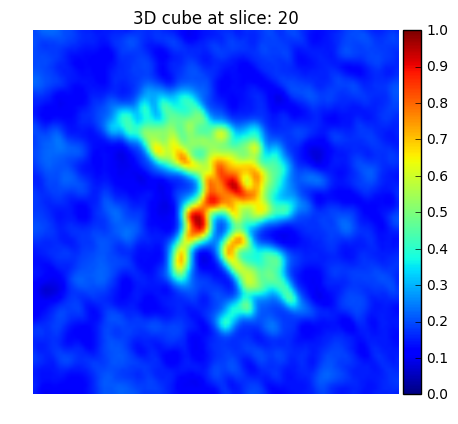

<function __main__.slices_plot>

In [6]:
interact(slices_plot, data=fixed(data), slc=(0, data.shape[0]-1))

## Euler-Lagrange Derivation

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}^3} L(x, y, z, u, u_x, u_y, u_z) \ d\Omega  = \int_{\Omega \subset \mathbb{R}^3}(u(x,y,z)-f_0(x,y,z))^2 + \alpha \ \Psi_1(u(x,y,z)-f_0(x,y,z)) + \beta \ \Psi_2(\left|\nabla u(x,y,z)\right|^2) \ d\Omega $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$
\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} - \frac{d}{dy}\frac{\partial L}{\partial u_y} -  \frac{d}{dz}\frac{\partial L}{\partial u_z}= 0$$

**2D case**:
$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

**3D case**:
$$
2(u -f) + \alpha \Psi_1'(u-f) - 2 \beta \left( 2 \Psi_2''\left(u_x^2+u_y^2+u_z^2\right) \left( u_x^2 u_{xx} + u_y^2 u_{yy}+  u_z^2 u_{zz} +2 \left( u_x u_y  u_{xy} + u_x u_z u_{xz} +  u_y u_z u_{yz} \right) \right) + \Psi_2'\left(u_x^2+u_y^2+u_z^2\right) \left(u_{xx} +u_{yy}+ u_{zz}\right)  \right) = 0
$$

whit boundary condition $u(\partial \Omega) = f(\partial \Omega)$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x,y,z) = \sum_{i=1}^N c_i \ \phi(x, y, z;\ x_i, y_i, z_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2 + (y-y_i)^2 + (z-z_i)^2}{2 \sigma_i^2}}$$

## Defining and computing the penalizing functions $\Psi_1$ and $\Psi_2$ (they will be the same)

In [7]:
"""
General Psi penalizing function (applicable in both cases)
"""
def psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 1.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('10*x**3 - 15*x**4 + 6*x**5')
    return ret

def d1psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 0.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('30*x**2 - 60*x**3 + 30*x**4')
    return lamb*ret

def d2psi(x, lamb=1.):
    x = lamb*x
    ret = np.empty(x.shape)
    mask0 = x<=0.
    mask1 = x>=1.
    mask01 = np.logical_and(np.logical_not(mask0),np.logical_not(mask1))
    ret[mask0] = 0.
    ret[mask1] = 0.
    #evaluation on 0-1
    x = x[mask01]
    ret[mask01] = ne.evaluate('60*x - 180*x**2 + 120*x**3')
    return (lamb**2)*ret

## $\phi$-RBF function to use and its derivatives

In [8]:
#minimal broadening of gaussians
minsig = 0.001

"""
RBF (Gaussian) functions and its derivatives
"""
def phi(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2)))')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2)] = 0.
    return retval

def phix(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(-1./(sig0**2+sig**2)) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * x')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phiy(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(-1./(sig0**2+sig**2)) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * y')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phiz(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(-1./(sig0**2+sig**2)) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * z')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phixx(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (x**2 - sig0**2 - sig**2)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phiyy(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (y**2 - sig0**2 - sig**2)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

def phizz(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (z**2 - sig0**2 - sig**2)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

# same as phiyx
def phixy(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (x*y)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

# same as phizx
def phixz(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (x*z)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

# same as phizy
def phiyz(x, y, z, sig, sig0=minsig, supp=5.):
    retval = ne.evaluate('(1./(sig0**2+sig**2)**2) * exp(-(x**2+y**2+z**2)/(2*(sig0**2+sig**2))) * (y*z)')
    if supp!=0.: retval[retval < np.exp(-0.5 * supp**2 * (sig0**2+sig**2))] = 0.
    return retval

## Euler-Lagrange function class definition

In [38]:
"""
Euler-Lagrange class definition
"""
class ELFunc():
    def __init__(self, dfunc, xe, ye, ze, xc, yc, zc, xb, yb, zb, c0, sig0, d1psi1=None, d1psi2=None, d2psi2=None,
                 a=0., b=0., lamb1=1., lamb2=1., base_level=0, square_c=True, compact_supp=False):
        f0 = np.array([dfunc([xe[i],ye[i],ze[i]]) for i in range(len(xe))]).ravel()
        fb = np.array([dfunc([xb[i],yb[i],zb[i]]) for i in range(len(xb))]).ravel()
        len_f0 = len(f0)
        len_c0 = len(c0)
        len_sig0 = len(sig0)
        Ne = len(xe)
        Nc = len(xc)
        Nb = len(xb)

        """ 
        Computing distance matrices
        """
        #distance matrices
        Dx = np.empty((Ne,Nc))
        Dy = np.empty((Ne,Nc))
        Dz = np.empty((Ne,Nc))
        for k in range(Ne):
            Dx[k,:] = xe[k]-xc
            Dy[k,:] = ye[k]-yc
            Dz[k,:] = ze[k]-zc
        #distance matrices for boundary points
        Dxb = np.empty((Nb,Nc))
        Dyb = np.empty((Nb,Nc))
        Dzb = np.empty((Nb,Nc))
        for k in range(Nb):
            Dxb[k,:] = xb[k]-xc
            Dyb[k,:] = yb[k]-yc
            Dzb[k,:] = zb[k]-zc
            
        """
        Computing Phi matrices
        """
        if compact_supp:
            phi_m = phi(Dx, Dy, Dz, sig0.reshape(1,-1))
            if b!=0.:
                phix_m = phix(Dx, Dy, Dz, sig0.reshape(1,-1))
                phiy_m = phiy(Dx, Dy, Dz, sig0.reshape(1,-1))
                phiz_m = phiz(Dx, Dy, Dz, sig0.reshape(1,-1))
                phixx_m = phixx(Dx, Dy, Dz, sig0.reshape(1,-1))
                phiyy_m = phiyy(Dx, Dy, Dz, sig0.reshape(1,-1))
                phizz_m = phizz(Dx, Dy, Dz, sig0.reshape(1,-1))
                phixy_m = phixy(Dx, Dy, Dz, sig0.reshape(1,-1))
                phixz_m = phixz(Dx, Dy, Dz, sig0.reshape(1,-1))
                phiyz_m = phiyz(Dx, Dy, Dz, sig0.reshape(1,-1))
        else:
            phi_m = phi(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
            if b!=0.:
                phix_m = phix(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
                phiy_m = phiy(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
                phiz_m = phiz(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
                phixx_m = phixx(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
                phiyy_m = phiyy(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
                phizz_m = phizz(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
                phixy_m = phixy(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
                phixz_m = phixz(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
                phiyz_m = phiyz(Dx, Dy, Dz, sig0.reshape(1,-1), supp=0.)
        
        """
        Storing important atributes
        """
        self.dfunc = dfunc
        self.f0 = f0
        self.fb = fb
        self.xe = xe; self.ye = ye; self.ze = ze
        self.xc = xc; self.yc = yc; self.zc = zc
        self.xb = xb; self.yb = yb; self.zb = zb
        self.Dx = Dx; self.Dxb = Dxb
        self.Dy = Dy; self.Dyb = Dyb
        self.Dz = Dz; self.Dzb = Dzb
        self.phi_m = phi_m
        if b!=0.:
            self.phix_m = phix_m
            self.phiy_m = phiy_m
            self.phiz_m = phiz_m
            self.phixx_m = phixx_m
            self.phiyy_m = phiyy_m
            self.phizz_m = phizz_m
            self.phixy_m = phixy_m
            self.phixz_m = phixz_m
            self.phiyz_m = phiyz_m
        self.c = c0
        self.sig = sig0
        self.d1psi1 = d1psi1
        self.d1psi2 = d1psi2
        self.d2psi2 = d2psi2
        self.a = a
        self.b = b
        self.lamb1 = lamb1
        self.lamb2 = lamb2
        self.base_level = base_level
        self.square_c = square_c
        self.compact_supp = compact_supp

    def set_centers(self, xc, yc, zc):
        xe = self.xe; ye = self.ye; ze = self.ze
        xb = self.xb; yb = self.yb; zb = self.zb
        Ne = len(xe)
        Nc = len(xc)
        Nb = len(xb)

        # re-computing distance matrices
        Dx = np.empty((Ne,Nc))
        Dy = np.empty((Ne,Nc))
        Dz = np.empty((Ne,Nc))
        for k in range(Ne):
            Dx[k,:] = xe[k]-xc
            Dy[k,:] = ye[k]-yc
            Dz[k,:] = ze[k]-zc

        # re-computing distance matrices for boundary points
        Dxb = np.empty((Nb,Nc))
        Dyb = np.empty((Nb,Nc))
        Dzb = np.empty((Nb,Nc))
        for k in range(Nb):
            Dxb[k,:] = xb[k]-xc
            Dyb[k,:] = yb[k]-yc
            Dzb[k,:] = zb[k]-zc
        
        self.xc = xc; self.yc = yc; self.zc = zc
        self.Dx = Dx; self.Dy = Dy; self.Dz = Dz
        self.Dxb = Dxb; self.Dyb = Dyb; self.Dzb = Dzb
        
    def set_c(self, c):
        self.c = c

    def set_sig(self, sig):
        self.sig = sig
        """
        Re-computing Phi matrices
        """
        if self.compact_supp:
            phi_m = phi(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
            if self.b!=0.:
                phix_m = phix(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phiy_m = phiy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phiz_m = phiz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phixx_m = phixx(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phiyy_m = phiyy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phizz_m = phizz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phixy_m = phixy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phixz_m = phixz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phiyz_m = phiyz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
        else:
            phi_m = phi(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
            if self.b!=0.:
                phix_m = phix(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phiy_m = phiy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phiz_m = phiz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phixx_m = phixx(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phiyy_m = phiyy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phizz_m = phizz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phixy_m = phixy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phixz_m = phixz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phiyz_m = phiyz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
    
    def F(self, X):
        N = len(X)/2
        if self.square_c: c = X[0:N]**2
        else: c = X[0:N]
        sig = X[N:]
        
        """
        Computing Phi matrices
        """
        if self.compact_supp:
            phi_m = phi(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
            if self.b!=0.:
                phix_m = phix(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phiy_m = phiy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phiz_m = phiz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phixx_m = phixx(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phiyy_m = phiyy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phizz_m = phizz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phixy_m = phixy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phixz_m = phixz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
                phiyz_m = phiyz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1))
        else:
            phi_m = phi(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
            if self.b!=0.:
                phix_m = phix(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phiy_m = phiy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phiz_m = phiz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phixx_m = phixx(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phiyy_m = phiyy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phizz_m = phizz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phixy_m = phixy(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phixz_m = phixz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
                phiyz_m = phiyz(self.Dx, self.Dy, self.Dz, sig.reshape(1,-1), supp=0.)
        
        """
        Computing u, ux, uy, ...
        """
        u = np.dot(phi_m, c) + self.base_level
        if self.b!=0.:
            ux = np.dot(phix_m, c)
            uy = np.dot(phiy_m, c)
            uz = np.dot(phiz_m, c)
            uxx = np.dot(phixx_m, c)
            uyy = np.dot(phiyy_m, c)
            uzz = np.dot(phizz_m, c)
            uxy = np.dot(phixy_m, c)
            uxz = np.dot(phixz_m, c)
            uyz = np.dot(phiyz_m, c)
        
        """
        Computing the EL equation
        """
        if self.b!=0.:
            el = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0, self.lamb1) - \
                2*self.b*(2*self.d2psi2(ux**2 + uy**2 + uz**2, self.lamb2) * (ux**2 * uxx + uy**2 * uyy + uz**2 * uzz + \
                2*(ux*uy*uxy + ux*uz*uxz + uy*uz*uyz)) + \
                self.d1psi2(ux**2 + uy**2 + uz**2, self.lamb2)*(uxx + uyy + uzz))
        else: 
            el = 2.*(u-self.f0) + self.a*self.d1psi1(u-self.f0, self.lamb1)
        
        """
        Boundary conditions (threshold must be added)
        """
        bc = np.dot(phi(self.Dxb, self.Dyb, self.Dzb, sig.reshape(1,-1)), c) + self.base_level - self.fb
        return np.concatenate([el,bc])

$$
2(u -f) + \alpha \Psi_1'(u-f) - 2 \beta \left( 2 \Psi_2''\left(u_x^2+u_y^2+u_z^2\right) \left( u_x^2 u_{xx} + u_y^2 u_{yy}+  u_z^2 u_{zz} +2 \left( u_x u_y  u_{xy} + u_x u_z u_{xz} +  u_y u_z u_{yz} \right) \right) + \Psi_2'\left(u_x^2+u_y^2+u_z^2\right) \left(u_{xx} +u_{yy}+ u_{zz}\right)  \right) = 0
$$

## Centers and evaluation points

#### Thresholded data: Over the RMS value.

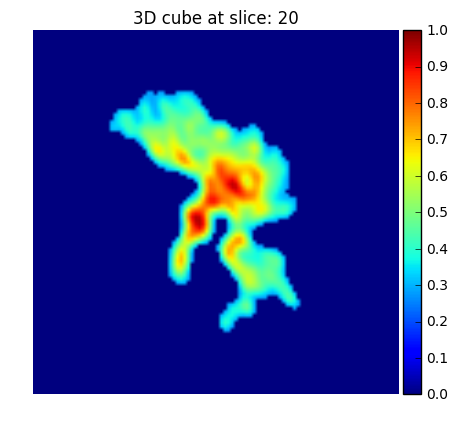

<function __main__.slices_plot>

In [39]:
_data = np.copy(data)
mask = data > 1.5*estimate_rms(data)
_data[~mask] = 0. 
interact(slices_plot, data=fixed(_data), slc=(0, _data.shape[0]-1))

In [40]:
"""
Boundary points
"""
#number of boundary points by side
Nb = 0
Nc = 400
Ne = 2*Nc-4*Nb

xb = []
yb = []
zb = []

for val in np.linspace(0., 1., Nb+1)[0:-1]:
    xb.append(val)
    yb.append(0.)
for val in np.linspace(0., 1., Nb+1)[0:-1]:
    xb.append(1.)
    yb.append(val)
for val in np.linspace(0., 1., Nb+1)[::-1][:-1]:
    xb.append(val)
    yb.append(1.)
for val in np.linspace(0., 1., Nb+1)[::-1][:-1]:
    xb.append(0.)
    yb.append(val)
xb = np.asarray(xb)
yb = np.asarray(yb)
zb = np.asarray(zb)
boundary_points = np.vstack([xb,yb,zb]).T

In [41]:
def _inv_gaussian_kernel(kernlen=3, sig=0.1):
    """
    Returns a 2D Gaussian kernel array.
    """
    interval = (2*sig+1.)/(kernlen)
    x = np.linspace(-sig-interval/2., sig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel.max()-kernel

def random_centers_generation(data, n_centers, cut_value_leq=None, cut_value_geq=None, power=5.):
    data = np.copy(data)
    if cut_value_leq is not None:
        mask = data <= cut_value_leq
    elif cut_value_geq is not None:
        mask = data >= cut_value_geq
    data **= power
    # fixed seed
    np.random.seed(0)
    # data dimensions
    l,m,n = data.shape
    
    # center points positions
    x = np.linspace(0., 1., l+2, endpoint=True)[1:-1]
    y = np.linspace(0., 1., m+2, endpoint=True)[1:-1]
    z = np.linspace(0., 1., n+2, endpoint=True)[1:-1]
    X,Y,Z = np.meshgrid(x,y,z, indexing='ij')
    points_positions = np.vstack( [ X.ravel(), Y.ravel(), Z.ravel() ]).T
    
    # array with indexes of such centers
    points_indexes = np.arange(0,points_positions.shape[0], dtype=int)
    
    # array with probabilities of selection for each center
    #prob = np.zeros(m+2, n+2)
    #prob[1:m+1, 1:n+1] = (data/data.sum())
    if isinstance(mask, np.ndarray):
        data[mask] = 0.
        prob = data/data.sum()
    else:
        prob = data/data.sum()
    
    # convolution kernel
    #K = np.array([[0.5, 0.5, 0.5], [0.5, 0., 0.5], [0.5, 0.5, 0.5]])
    #K = _inv_gaussian_kernel(kernlen=3, sig=3.)
    
    selected = []
    while len(selected)!=n_centers:
        sel = np.random.choice(points_indexes, size=1 , p=prob.ravel(), replace=False)[0]
        # border pixels can't be selected
        index0 = sel / (m*n)
        index1 = (sel/ n) % m 
        index2 = sel % n
        if index0==0 or index0==l-1 or index1==0 or index1==m-1 or index2==0 or index2==n-1: continue
        selected.append(sel)
        # update the pixel probabilities array
        #prob[index0-1:index0+2, index1-1:index1+2] *= K
        prob[index0-1:index0+2, index1-1:index1+2, index2-1:index2+2] *= 0.5
        prob[index0, index1, index2] *= 0.
        prob /= prob.sum()
        
    return points_positions[selected]

#### Approach #1

In [17]:
centers = random_centers_generation(data, 2*Nc, cut_value_leq=1.5*estimate_rms(data), power=2.)
center_points = centers[0:Nc]
collocation_points = centers

#### Approach #2

In [14]:
center_points = random_centers_generation(data, Nc, cut_value_leq=estimate_rms(data), power=3.)
extra_points = random_centers_generation(1-data, Nc, cut_value_geq=1-estimate_rms(data), power=3.)
collocation_points = np.vstack((center_points, extra_points))

### Visualization of points

In [18]:
xc = center_points[:,0]
yc = center_points[:,1]
zc = center_points[:,2]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
ze = collocation_points[:,2]

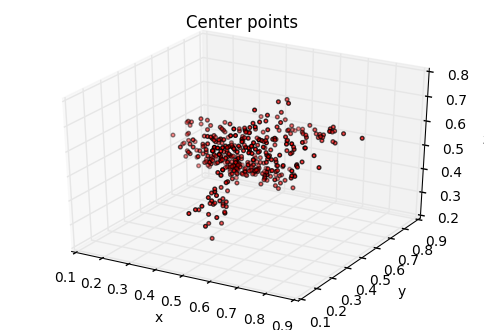

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xc, yc, zc, c='r', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Center points')
plt.show()

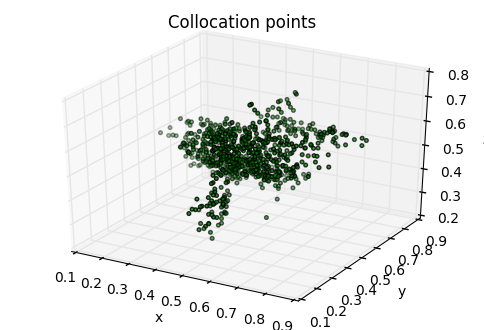

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xe, ye, ze, c='g', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Collocation points')
plt.show()

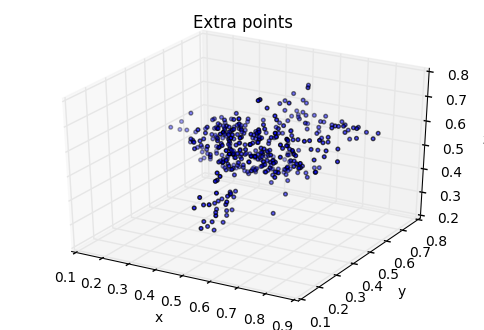

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xe[Nc:], ye[Nc:], ze[Nc:], c='b', marker='o', s=7)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Extra points')
plt.show()

## Initial Conditions

In [22]:
"""
Building distances matrix
"""
Nc = center_points.shape[0]
Dx = np.empty((Nc,Nc))
Dy = np.empty((Nc,Nc))
for k in range(Nc):
    Dx[k,:] = xc[k]-xc
    Dy[k,:] = yc[k]-yc
dist_matrix = np.sqrt(Dx**2+Dy**2)

In [42]:
def estimate_initial_guess(center_points, dist_matrix, dfunc, R=0.05, minsig=0.001, method='min_dist'):
    m = center_points.shape[0]
    c_arr = np.empty(m, dtype=float)
    sig_arr = np.empty(m, dtype=float)
    
    if method=='mean_dist':
        f = 1./sqrt(log(2.))
        mean_dist = np.zeros(m, dtype=float)
        num_neigh = np.zeros(m, dtype=float)   
        for i in range(m):
            for j in range(m):
                #dont take into account the same point
                if i==j: continue
                d = dist_matrix[i,j]
                #dont take into account points outside R radius
                if d>R: continue
                num_neigh[i] += 1
                mean_dist[i] += d
            """
            Key Idea: The mean distance to neighbors acurrs when the
            gaussian function has decayed to the half
            """
            if num_neigh[i]==0:
                c_arr[i] = dfunc(*center_points[i])[0]
                sig_arr[i] = minsig
            else:
                mean_dist[i] /= num_neigh[i]
                c_arr[i] = dfunc(*center_points[i])[0]/num_neigh[i]
                #c_arr[i] = dfunc(*center_points[i])[0]*mean_dist[i]**2
                sig_arr[i] = f*mean_dist[i]
                
    elif method=='min_dist':
        min_dist = np.inf*np.ones(m, dtype=float)
        num_neigh = np.zeros(m, dtype=float)
        #first we find the distance to the nearest neighbor
        for i in range(m):
            for j in range(m):
                #dont take into account the same point
                if i==j: continue
                d = dist_matrix[i,j]
                if d<min_dist[i]: min_dist[i] = d
        #second, we find the number of neighbors on the neighborhood
        for i in range(m):
            for j in range(m):
                #dont take into account the same point
                if i==j: continue
                d = dist_matrix[i,j]
                if d > 3*min_dist[i]: continue
                num_neigh[i] += 1
            """
            some explanation here
            """
            if num_neigh[i]==0:
                c_arr[i] = dfunc(*center_points[i])[0]
                sig_arr[i] = minsig
            else:
                c_arr[i] = dfunc(*center_points[i])[0]/(num_neigh[i]+1)
                sig_arr[i] = min_dist[i] 
    return (c_arr,sig_arr)

In [43]:
"""
Initial parameters estimation
"""
#c0, sig0 = estimate_initial_guess(center_points, f, R=0.009, method='mean_dist')
#c0, sig0 = estimate_initial_guess(center_points, dist_matrix, f, minsig=minsig, method='min_dist')
c0 = 0.01 * np.ones(Nc)
sig0 = 0.01 * np.ones(Nc)

## Visualizing the initial solution

In [44]:
#plot_sol(c0, sig0, xc, yc, base_level=estimate_rms(data))
#plot_sol(c0, sig0, xc, yc, base_level=0., compact_supp=False)
#params_plot(c0, sig0, xc, yc, square_c=True)
#params_distribution_plot(c0, sig0, square_c=True)

# Experiments

In [48]:
def el_solver(elf, method='iterative', n_iter=5, verbose=True, base_level=0., 
              square_c=True, compact_supp=False, step_iter=2000, max_iter=100000):
    # number of centers/parameters
    Nc = len(elf.xc)

    if method=='exact':
        residual_variance = []
        residual_entropy = []
        residual_rms = []
        iter_list = range(step_iter, max_iter+1, step_iter)
        
        for it in iter_list:
            print('\n'+'#'*90)
            print('Results after {0} iterations'.format(it))
            print('#'*90)
            # lm optimization
            sol = sp.optimize.root(elf.F, np.concatenate([elf.c, elf.sig]), method='lm', options={'maxiter':step_iter})
            sol_length = len(sol.x)
            opt_c = sol.x[0:sol_length/2]
            opt_sig = sol.x[sol_length/2:]
            
            # variation of c and sig
            delta_c = np.linalg.norm(opt_c-elf.c)
            delta_sig = np.linalg.norm(opt_sig-elf.sig)
            
            # searching for noisy gaussians (and removing them)
            mask = np.abs(opt_sig)<1.
            if np.any(~mask):
                print('Noisy gaussians detected and removed! \n')
                opt_c = opt_c[mask]
                opt_sig = opt_sig[mask]
                xc = elf.xc[mask]
                yc = elf.yc[mask]
                zc = elf.zc[mask]
                elf.set_centers(xc, yc, zc)
            
            # update of best parameters
            elf.set_c(opt_c)
            elf.set_sig(opt_sig)
            
            # residual stats
            #var,entr,rms = compute_residual_stats(elf.dfunc, opt_c, opt_sig, elf.xc, elf.yc, base_level=base_level, 
            #         square_c=square_c, compact_supp=compact_supp)
            
            # appending residual variance, entropy and rms
            #residual_variance.append(var)
            #residual_entropy.append(entr)
            #residual_rms.append(rms)
            
            print('Variation on c = {0}'.format(delta_c))
            print('variation on sig = {0}'.format(delta_sig))
            print('\nsuccess: {0}'.format(sol['success']))
            print('\nstatus: {0}'.format(sol['status']))
            print('\nmessage: {0}'.format(sol['message']))
            print('\nnfev: {0}'.format(sol['nfev']))
            if sol['success']: break
        
        print('\n \n' + '#'*90)    
        print('FINAL RESULTS:')
        print('#'*90)
        
        # plots generation
        # solution_plot(elf.dfunc, opt_c, opt_sig, elf.xc, elf.yc, base_level=base_level, square_c=square_c, compact_supp=compact_supp)
        # params_plot(elf.c, elf.sig, elf.xc, elf.yc, square_c=square_c)
        # params_distribution_plot(elf.c, elf.sig, square_c=square_c)
        # residual_plot(residual_variance, residual_entropy, residual_rms, iter_list[0:len(residual_rms)])
    
    if method=='mixed':
        print('\n'+'#'*90)
        print('Iteration: 0  -  Optimization on both c and sig parameters')
        print('#'*90)
        sol = sp.optimize.root(elf.F, np.concatenate([elf.c, elf.sig]), method='lm', options={'maxiter':10000}, callback=calllback)
        opt_c = sol.x[0:Nc]
        opt_sig = sol.x[Nc:]
        delta_c = np.linalg.norm(opt_c-elf.c)
        delta_sig = np.linalg.norm(opt_sig-elf.sig)
        elf.set_c(opt_c)
        elf.set_sig(opt_sig)
        solution_plot(elf.dfunc, elf.c, elf.sig, elf.xc, elf.yc, base_level=base_level, 
                            square_c=square_c, compact_supp=compact_supp)
        params_plot(elf.c, elf.sig, elf.xc, elf.yc, square_c=square_c)
        params_distribution_plot(elf.c, elf.sig, square_c=square_c)

        print('Variation on c={0}'.format(delta_c))
        print('Variation on sig={0}'.format(delta_sig))
        print('\nmessage: {0}'.format(sol['message']))
        print('\nsuccess: {0}'.format(sol['success']))
    
    if method=='iterative' or method=='mixed':
        residual_variance = []
        residual_entropy = []
        residual_rms = []
        
        #print('\n'+'#'*90)
        #print('Initial Guess')
        #print('#'*90)
        solution_plot(elf.dfunc, elf.c, elf.sig, elf.xc, elf.yc, base_level=base_level, square_c=square_c)
        #params_plot(elf.c, elf.sig, elf.xc, elf.yc, square_c=square_c)
        #params_distribution_plot(elf.c, elf.sig, square_c=square_c)
        #residual_variance.append(var)
        #residual_entropy.append(entr)
        #residual_rms.append(rms)
        
        for it in range(n_iter):
            print('\n'+'#'*90)
            print('Iteration: {0}  -  Optimization on c parameter'.format(it))
            print('#'*90)
            #solve for c
            sol = sp.optimize.root(elf.F1, elf.c, method='lm', options={'maxiter':10000})
            opt_c = sol.x
            delta_c = np.linalg.norm(opt_c-elf.c)
            elf.set_c(opt_c)
            #title = 'Best solution at iter={0} and improved c'.format(i)
            solution_plot(elf.dfunc, elf.c, elf.sig, elf.xc, elf.yc, base_level=base_level, 
                                    square_c=square_c, compact_supp=compact_supp)
            params_plot(elf.c, elf.sig, elf.xc, elf.yc, square_c=square_c)
            params_distribution_plot(elf.c, elf.sig, square_c=square_c)
            print('Variation on c={0}'.format(delta_c))
            print('\nnfev: {0}'.format(sol['nfev']))
            print('\nmessage: {0}'.format(sol['message']))
            print('\nsuccess: {0}'.format(sol['success']))
            if square_c:
                print('\nmax c and position: {0} and {1}'.format(np.max(opt_c**2), np.argmax(opt_c**2)))
            else:
                print('\nmax c and position: {0} and {1}'.format(np.max(opt_c), np.argmax(opt_c)))

            # residual stats
            var,entr,rms = compute_residual_stats(opt_c, opt_sig, elf.xc, elf.yc, base_level=base_level, 
                        square_c=square_c, compact_supp=compact_supp)
            
            #appending residual variance and entropy
            residual_variance.append(var)
            residual_entropy.append(entr)
            residual_rms.append(rms)

            print('\n'+'#'*90)
            print('Iteration: {0}  -  Optimization on sig parameter'.format(it))
            print('#'*90)
            #solve for sig
            sol = sp.optimize.root(elf.F2, elf.sig, method='lm', options={'maxiter':10000})
            opt_sig = sol.x
            delta_sig = np.linalg.norm(opt_sig-elf.sig)
            elf.set_sig(opt_sig)
            #title = 'Best solution at iter={0} and improved sig'.format(i)
            solution_plot(elf.dfunc, elf.c, elf.sig, elf.xc, elf.yc, base_level=base_level, 
                                    square_c=square_c, compact_supp=compact_supp)
            params_plot(elf.c, elf.sig, elf.xc, elf.yc, square_c=square_c)
            params_distribution_plot(elf.c, elf.sig, square_c=square_c)
            
            print('Variation on sig={0}'.format(delta_sig))
            print('\nnfev: {0}'.format(sol['nfev']))
            print('\nmessage: {0}'.format(sol['message']))
            print('\nsuccess: {0}'.format(sol['success']))
            print('\nmax sig and position: {0} and {1}'.format(np.max(opt_sig**2), np.argmax(opt_sig**2)))
            print('\nmin sig and position: {0} and {1}'.format(np.min(opt_sig**2), np.argmin(opt_sig**2)))
            print('-------------------------------------------------------------')
            
            # residual stats
            var,entr,rms = compute_residual_stats(opt_c, opt_sig, elf.xc, elf.yc, base_level=base_level, 
                        square_c=square_c, compact_supp=compact_supp)

            #appending residual variance, entropy and RMS
            residual_variance.append(var)
            residual_entropy.append(entr)
            residual_rms.append(rms)

        print('\n \n' + '#'*90)    
        print('SOME FINAL RESULTS:')
        print('#'*90)
        plt.figure(figsize=(12,5))
        plt.subplot(1,3,1)
        plt.xlim(-0.2, (2.*n_iter-1)+0.2)
        plt.plot(range(2*n_iter), residual_rms, 'go-')
        plt.title('Residual RMS')        
        plt.subplot(1,3,2)
        plt.xlim(-0.2, (2.*n_iter-1)+0.2)
        plt.plot(range(2*n_iter), residual_variance, 'bo-')
        plt.title('Residual variance')
        plt.subplot(1,3,3)
        plt.xlim(-0.2, (2.*n_iter-1)+0.2)
        plt.plot(range(2*n_iter), residual_entropy, 'ro-')
        plt.title('Residual entropy')
        plt.show()

## Experiments 1
The following instances test with different settings combinations for: square_c and support

In [49]:
"""
ELFunc instantiations
"""

base_level = 1.5*estimate_rms(data)

elf01 = ELFunc(dfunc, xe, ye, ze, xc, yc, zc, xb, yb, zb, np.sqrt(c0), sig0, a=1., lamb1=1., d1psi1=d1psi, 
               d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, square_c=True, compact_supp=True)

### C-squared and `base_level=RMS`

In [50]:
el_solver(elf01, method='exact', base_level=base_level, square_c=True, step_iter=2000, max_iter=50000)


##########################################################################################
Results after 2000 iterations
##########################################################################################
Noisy gaussians detected and removed! 

Variation on c = 0.45817444419
variation on sig = 3.18724427871

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2407

##########################################################################################
Results after 4000 iterations
##########################################################################################
Variation on c = 1.3690204244
variation on sig = 0.291972203541

success: False

status: 5

message: Number of calls to function has reached maxfev = 2000.

nfev: 2401

##########################################################################################
Results after 6000 iterations
############################################################################

In [51]:
u_sol = compute_solution(elf01.c, elf01.sig, elf01.xc, elf01.yc, elf01.zc, dims=data.shape)

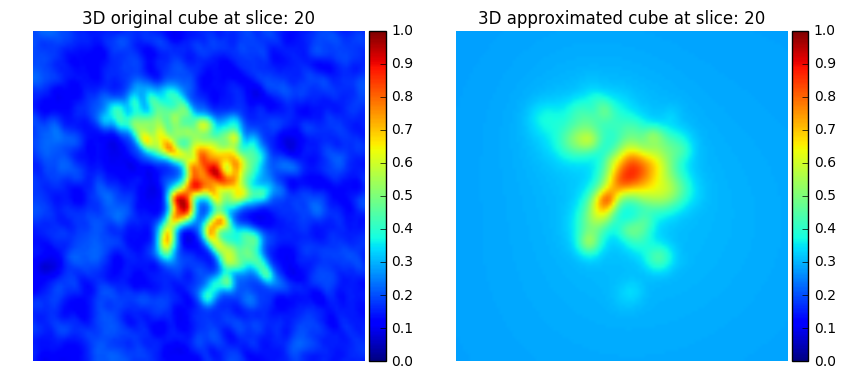

<function __main__.comparative_slices_plot>

In [52]:
interact(comparative_slices_plot, data1=fixed(data), data2=fixed(u_sol+base_level), slc=(0, _data.shape[0]-1))

In [81]:
data.size*0.01

4100.0

In [82]:
np.sum(data > base_level)

14445